In [1]:
import pandas as pd
import numpy as np
import os
import time
import matplotlib.pyplot as plt
import matplotlib.backends
from matplotlib.backends.backend_pdf import PdfPages
from sklearn import linear_model
import anndata as an
import scipy



In [2]:
# Enter the name of your input file here
inputFile = "seurat.txt"
# Input parameters
nGene = 300
nCell = 3

try:
    os.stat("ComplexityPlots")
except:
    os.mkdir("ComplexityPlots")
    
# Read in DGE Files    
fileNames = pd.read_csv(inputFile, sep = "\t")
fileNames

,Sample,DGE SilePath,Reads SilePath,Soup
0,S4,L:/Duncan/MZTreg_final/dLN/DGE/S4_20211025_DGE...,L:/Duncan/MZTreg_final/dLN/DGE/S4_20211025_rea...,L:/Duncan/MZTreg_final/dLN/DGE/S1_20211025_sou...
1,S5,L:/Duncan/MZTreg_final/dLN/DGE/S5_20211025_DGE...,L:/Duncan/MZTreg_final/dLN/DGE/S5_20211025_rea...,L:/Duncan/MZTreg_final/dLN/DGE/S1_20211025_sou...
2,S6,L:/Duncan/MZTreg_final/dLN/DGE/S6_20211025_DGE...,L:/Duncan/MZTreg_final/dLN/DGE/S6_20211025_rea...,L:/Duncan/MZTreg_final/dLN/DGE/S1_20211025_sou...
3,S7,L:/Duncan/MZTreg_final/dLN/DGE/S7_20211025_DGE...,L:/Duncan/MZTreg_final/dLN/DGE/S7_20211025_rea...,L:/Duncan/MZTreg_final/dLN/DGE/S1_20211025_sou...
4,S8,L:/Duncan/MZTreg_final/dLN/DGE/S8_20211025_DGE...,L:/Duncan/MZTreg_final/dLN/DGE/S8_20211025_rea...,L:/Duncan/MZTreg_final/dLN/DGE/S1_20211025_sou...
5,S9,L:/Duncan/MZTreg_final/dLN/DGE/S9_20211025_DGE...,L:/Duncan/MZTreg_final/dLN/DGE/S9_20211025_rea...,L:/Duncan/MZTreg_final/dLN/DGE/S1_20211025_sou...
6,S10,L:/Duncan/MZTreg_final/dLN/DGE/S10_20211025_DG...,L:/Duncan/MZTreg_final/dLN/DGE/S10_20211025_re...,L:/Duncan/MZTreg_final/dLN/DGE/S1_20211025_sou...
7,S11,L:/Duncan/MZTreg_final/dLN/DGE/S11_20211025_DG...,L:/Duncan/MZTreg_final/dLN/DGE/S11_20211025_re...,L:/Duncan/MZTreg_final/dLN/DGE/S1_20211025_sou...


In [3]:
tic = time.time()
first = True
for i in range(0,8):
        
    # read and print sample name
    sampName = str(fileNames.Sample.iloc[i])
    print(sampName)
        
    # read in DGE and readCounts files, calculate nUMI
    cells = pd.read_csv(fileNames.values[i,1], index_col = 0, header = 0, delim_whitespace = True)
    nUMIs = cells.sum(axis = 0)
    readCounts = pd.read_csv(fileNames.values[i,2], index_col = 0, header = 0, delim_whitespace = True)
    readCounts = readCounts.reindex(index = list(cells))
    cells = cells.loc[~cells.index.duplicated(),:]    
    cells
        
    # plotting 
    spam = plt.figure()
    plt.rcParams['figure.figsize'] = [7,8]
    plt.plot(readCounts['ExonReads'], nUMIs, 'ko')
    plt.xlabel('Total Reads')
    plt.ylabel('Number of UMIs')
    plt.title(str(sampName) + " Complexity")  
    regr = linear_model.LinearRegression()
    regr.fit(X = nUMIs.values.reshape(-1,1), y = readCounts['ExonReads'].values)
    plt.plot(X = nUMIs.values.reshape(-1,1), Y = regr.predict(nUMIs.values.reshape(-1,1)))
    c = np.array2string(regr.coef_[0])
    plt.annotate("Complexity = " + c, (0,plt.ylim()[1]*.95))
    plt.savefig(fname = "ComplexityPlots/" + str(sampName) + '.png')
    plt.close()
        
    # filter by nGene
    keepcells = (cells.values>0).sum(axis = 0) > nGene
    keepgenes = (cells.values > 0).sum(axis = 1) > nCell
    cells = cells.loc[keepgenes, keepcells]
        
    readCounts = readCounts[:][keepcells]
    n = cells.shape[1]

    # rename columns of data frame to prevent barcode collisions
    identsadd = [sampName]*n
    index = [identsadd[i] + "_" + str(i) for i in range(0, len(identsadd))]
    cells.columns = index
    bcs = readCounts.index.values
    print(len(bcs))
    
    if first:
        cellsAll = cells.copy()
        readCountsAll = readCounts.copy()
        bcsAll= bcs.copy()
        first = False
        idents_all = identsadd

    else:
        cellsAll = pd.DataFrame.join(cellsAll, cells, how = 'outer')
        readCountsAll = readCountsAll.append(readCounts)
        bcsAll = np.append(bcsAll, bcs)
        idents_all = np.append(idents_all, identsadd)
        
toc = time.time()
print(toc - tic)
cellsAll = cellsAll.fillna(0)
cellsAll = cellsAll.reset_index()



S4
5454
S5
7195
S6
3206
S7
3696
S8
5501
S9
1370
S10
4655
S11
4950
716.7929201126099


In [4]:
import pyarrow.feather
pyarrow.feather.write_feather(cellsAll, 'allcellsAll.feather')  
pyarrow.feather.write_feather(readCountsAll, 'allreadCountsAll.feather')
np.savetxt('allbcs.txt', bcsAll, fmt = "%s")

In [5]:
import sys
sys.path.append('../../')
from functions import *

# read in and fix data
cells = pd.read_feather('allcellsAll.feather')
cells.index = cells.loc[:, 'Gene']
cells = cells.drop('Gene', axis = 1)

filtered out 125 genes that are detected in less than 3 cells
filtered out 17 cells that have less than 300 genes expressed
AnnData object with n_obs × n_vars = 36010 × 14333
    obs: 'orig', 'bc', 'n_genes'
    var: 'n_cells'
normalizing by total count per cell
    finished (0:00:04): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
extracting highly variable genes
    Gene indices [5511, 5759, 14296] fell into a single bin: their normalized dispersion was set to 1.
    Decreasing `n_bins` will likely avoid this effect.
    finished (0:00:04)
regressing out n_counts


C:\Users\dmorgan\AppData\Local\Continuum\anaconda3\envs\seqwell\lib\site-packages\anndata\_core\anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'orig' as categorical
C:\Users\dmorgan\AppData\Local\Continuum\anaconda3\envs\seqwell\lib\site-packages\anndata\_core\anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'bc' as categorical


    finished (0:02:49)
linear scaling
computing PCA
    with n_comps=50
    finished (0:00:13)
    and added
    'X_pca', the PCA coordinates (adata.obs)
    'PC1', 'PC2', ..., the loadings (adata.var)
    'pca_variance', the variance / eigenvalues (adata.uns)
    'pca_variance_ratio', the variance ratio (adata.uns)
computing neighbors
    computing neighbors
    using 'X_pca' with n_pcs = 10
    computed neighbors (0:00:46)
    computed connectivities (0:00:08)
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:55)
computing UMAP


  0%|          | 0/200 [00:00<?, ?it/s]

    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:01:09)
running Leiden clustering
    finished: found 13 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:02:58)


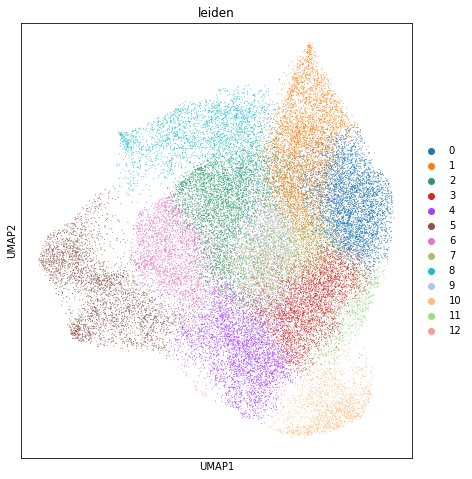

In [6]:
# SCANPY
sc.settings.verbosity = 4
adata = an.AnnData(cells.values.transpose())
adata.var_names = cells.index
adata.obs_names = cells.columns
bcs = np.loadtxt('allbcs.txt', dtype = str)
adata.obs['orig'] =[x.split('_')[0] for x in adata.obs_names]
adata.obs['bc']= bcs
adata.obs_names_make_unique()
adata.var_names_make_unique()
adata
sc.pp.filter_genes(adata, min_cells = 3)
sc.pp.filter_cells(adata, min_genes = 300)
print(adata)

sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)
adata.raw = adata

adata = process(adata)


In [7]:
metadata = pd.read_csv('metadata.csv', index_col = 0)
adata.obs['location'] = [metadata.Location.loc[x] for x in adata.obs.orig]
adata.obs['condition'] = [metadata.Condition.loc[x] for x in adata.obs.orig]


C:\Users\dmorgan\AppData\Local\Continuum\anaconda3\envs\seqwell\lib\site-packages\anndata\_core\anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'location' as categorical
C:\Users\dmorgan\AppData\Local\Continuum\anaconda3\envs\seqwell\lib\site-packages\anndata\_core\anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'condition' as categorical


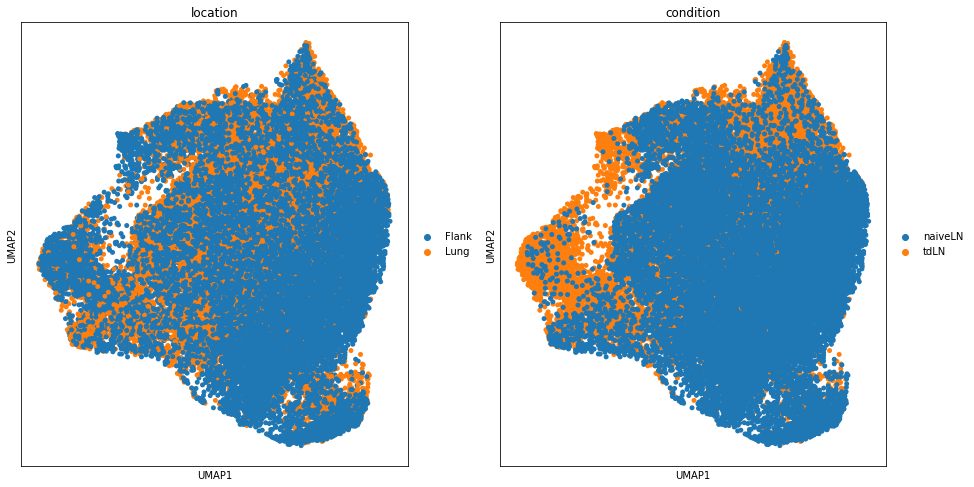

In [8]:
sc.pl.umap(adata, size = 100, color = ['location', 'condition'])

In [9]:
import pyarrow.feather
def seuratExport(adata, fname):
    df = pd.DataFrame(adata.raw.X.transpose())
    df.columns = adata.obs_names
    df.index = adata.raw.var_names
    df = df.reset_index()
    pyarrow.feather.write_feather(df, fname + '.feather') 
    adata.obs.to_csv(fname + '_meta.txt')
    
seuratExport(adata, 'treg_ln1')
